In [9]:
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define classes

## Define `person`

In [10]:
class person:
    def __init__(
        self,
        name,
        amt_cons_food_per_day,
        amt_cons_cloth_per_day,
        amt_prod_food_per_day, 
        amt_prod_cloth_per_day,
        prices,
    ):  
        '''
        Parameters
        ----------
        prices: dict
            Prices of each good
        '''
        self.name = name

        self.amt_food = 10
        self.amt_cloth = 10
        self.money = 100
        
        self.amt_cons_food_per_day = amt_cons_food_per_day
        self.amt_cons_cloth_per_day = amt_cons_cloth_per_day
        
        self.amt_prod_food_per_day = amt_prod_food_per_day
        self.amt_prod_cloth_per_day = amt_prod_cloth_per_day
        
        self.prices = prices

    
    
    def consume(self):
        if self.amt_food >= self.amt_cons_food_per_day:
            self.amt_food = self.amt_food - self.amt_cons_food_per_day
        else:
            raise Exception('No food to consume')
        
        if self.amt_cloth >= self.amt_cons_cloth_per_day:
            self.amt_cloth = self.amt_cloth - self.amt_cons_cloth_per_day
        else:
            raise Exception('No cloth to consume')


    
    def _produce_food(self):
        self.amt_food = self.amt_food + self.amt_prod_food_per_day

    def _produce_cloth(self):
        self.amt_cloth = self.amt_cloth + self.amt_prod_cloth_per_day
        
    def _get_prod_func(self):
        self.prod_funcs = [self._produce_food, self._produce_cloth]
        
    def produce_goods(self): 
        '''
        Produce goods, more likely to produce goods that person is good at.
        '''
        goods = pd.Series({
            'food': self.amt_prod_food_per_day,
            'cloth': self.amt_prod_cloth_per_day
        })

        cumulative_p = np.cumsum(goods / goods.sum())
        self._get_prod_func()

        rand_num = np.random.random()
        for prod_func, cp in zip(self.prod_funcs, cumulative_p):
            if rand_num < cp:
                prod_func()
                break
        
    def trade(self, other, prices, log_list):
        '''
        Trades with another `person`.
        '''
        # Determine trading probabilities `p`
        p = pd.Series({
            'no_trade': np.nan,
            'b_f': np.nan,
            'b_c': np.nan,
            })
        if (self.amt_food // self.amt_cons_food_per_day <= 1):
            p['no_trade'] = 0
            p['b_f'] = 1
        elif (self.amt_cloth // self.amt_cons_cloth_per_day <= 1):
            p['no_trade'] = 0
            p['b_f'] = 0
        else:
            p['no_trade'] = 0.1 # 10% a person simply doesn't want to trade
            p_trade = 1 - p['no_trade']
            p['b_f'] = p_trade * (1 - self.amt_food / (self.amt_cloth + self.amt_food))
        p['b_c'] =  1 - p['no_trade'] - p['b_f']

        # Trade according to `p`
        choice = np.random.choice([0, 1, 2], size=1, p=p)
        if choice == 0:
            log_list.append(self.name + ' didn\'t trade.')
        elif choice == 1:
            self._buy_food(other, prices, log_list)
        elif choice == 2:
            self._buy_cloth(other, prices, log_list)
        else:
            raise Exception('Invalid choice.')
                
        
    def _buy_food(self, seller, prices, log_list):
        '''
        Buys 1 amount of food.
        '''
        if seller.amt_food > 1:         
            if self.money > prices['food'] * 1:
                self.money = self.money - 1 * prices['food']
                seller.money = seller.money + 1 * prices['food']
                
                self.amt_food = self.amt_food + 1
                seller.amt_food = seller.amt_food - 1
                
                log_list.append(self.name + ' bought 1 food')
        else:
            log_list.append('Seller ' + seller.name + ' doen\'t have enough to sell.')

    def _buy_cloth(self, seller, prices, log_list):
        '''
        Buys 1 amount of cloth.
        '''
        if seller.amt_cloth > 1:
            if self.money > prices['cloth'] * 1:
                self.money = self.money - 1 * prices['cloth']
                seller.money = seller.money + 1 * prices['cloth']
                
                self.amt_cloth = self.amt_cloth + 1
                seller.amt_cloth = seller.amt_cloth - 1
                
                log_list.append(self.name + ' bought 1 cloth')
        else:
            log_list.append('Seller ' + seller.name + ' doen\'t have enough to sell.')

    def calc_tot_wealth(self, prices):
        '''
        Calculates total money value.
        '''
        wealth = prices['food'] * self.amt_food + prices['cloth'] * self.amt_cloth + \
            self.money
        self.wealth = wealth

In [11]:
# tmp = person(name='test',
#         amt_prod_food_per_day=1, 
#         amt_prod_cloth_per_day=5,
#         px_1_food_in_cloth=2)

## Define `economy`

In [12]:
class economy:
    
    def __init__(
        self,
        run_days = np.arange(0, 20, step=1),
        prices = {},
        # **kwargs, include list of persons
    ):
        '''
        Parameters
        ----------
        run_days: int
            Number of days to run the economy.
        '''
        self.run_days = run_days
        self.log = ''
        self.prices = prices
        
        # Define persons in economy
        self.farmer = person(
            name = 'farmer',
            amt_cons_food_per_day = 1,
            amt_cons_cloth_per_day = 1,
            amt_prod_food_per_day = 6, 
            amt_prod_cloth_per_day = 3,
            prices = prices
        )

        self.carpenter = person(
            name = 'carpenter',
            amt_cons_food_per_day = 1,
            amt_cons_cloth_per_day = 1,
            amt_prod_food_per_day = 3, 
            amt_prod_cloth_per_day = 6,
            prices = prices
        )
        
    def log_amounts(self, log_list):
        log_list.append(
            "Farmer: Food: {0}, Cloth: {1}, Money: {2}".format(
                self.farmer.amt_food, self.farmer.amt_cloth, self.farmer.money
        ))
        log_list.append(
            "Carpenter: Food: {0}, Cloth: {1}, Money: {2}".format(
                self.carpenter.amt_food, self.carpenter.amt_cloth, self.carpenter.money
        ))
    
    
    def run_economy(self):
        tot_amt_farmer = {}
        tot_amt_carpenter = {}
        log_list = []
        for i in self.run_days:
            print(i)
            log_list.append('Day ' + str(i) + ' starts')
            
            self.log_amounts(log_list)
            
            # Produce
            log_list.append(f'******\nProducing...')
            
            self.farmer.produce_goods()
            self.carpenter.produce_goods()
            
            log_list.append(f'Produce done')
            
            self.log_amounts(log_list)
            
            # Trade
            log_list.append(f'******\nTrading...')
            
            self.farmer.trade(self.carpenter, self.prices, log_list)
            self.carpenter.trade(self.farmer, self.prices, log_list)
            
            log_list.append(f'Trade done')
            
            self.log_amounts(log_list)
            
            # Consume
            log_list.append(f'******\nConsuming...')
            self.farmer.consume()
            self.carpenter.consume()
            log_list.append(f'Consume done')
            
            self.log_amounts(log_list)

            # Bookkeeping
            self.farmer.calc_tot_wealth(self.prices)
            self.carpenter.calc_tot_wealth(self.prices)
            
            tot_amt_farmer[i] = {
                'food': self.farmer.amt_food, 
                'cloth': self.farmer.amt_cloth,
                'money': self.farmer.wealth
            }
            tot_amt_carpenter[i] = {
                'food': self.carpenter.amt_food, 
                'cloth': self.carpenter.amt_cloth,
                'money': self.carpenter.wealth
            }

            log_list.append('Day ' + str(i) + ' ends')
            log_list.append('-------------------------')
        
        # total wealth per person
        df_tot_amt_farmer = pd.DataFrame.from_dict(tot_amt_farmer, orient='index')
        df_tot_amt_carpenter = pd.DataFrame.from_dict(tot_amt_carpenter, orient='index')
        
        # total wealth of economy
        tot_wealth = (
            df_tot_amt_farmer['money'] + df_tot_amt_carpenter['money']
        )
        
        self.farmer.df_tot_amt = df_tot_amt_farmer
        self.carpenter.df_tot_amt = df_tot_amt_carpenter
        self.tot_wealth = tot_wealth
        
        # Logging
        self.log = '\n'.join(log_list)
        with open("logs/log_file.txt", "w") as file:
            file.write(self.log)
        print("Log saved to log_file.txt!")


In [13]:
def plot_wealth(econ):
    plt.plot(econ.run_days, econ.tot_wealth, marker='o')
    plt.xlabel("Days")
    plt.ylabel("Total wealth (in money)")
    plt.title("Total wealth of the economy over time")
    plt.show()

def plot_person(person):
    person.df_tot_amt.plot(marker='o')

In [14]:
prices = {
    'food': 2,
    'cloth': 3
}

In [15]:
econ = economy(prices=prices)

In [16]:
econ.run_economy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Log saved to log_file.txt!


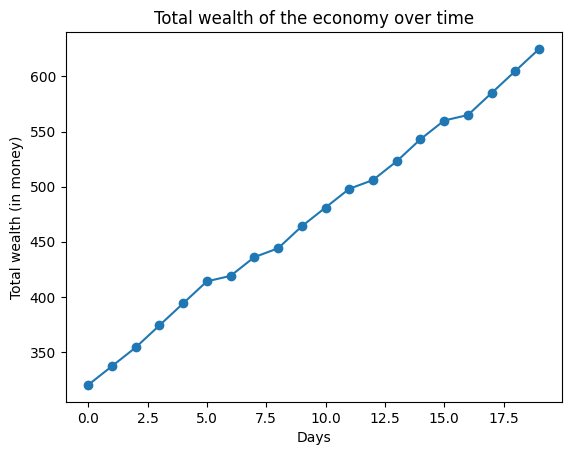

In [17]:
plot_wealth(econ)

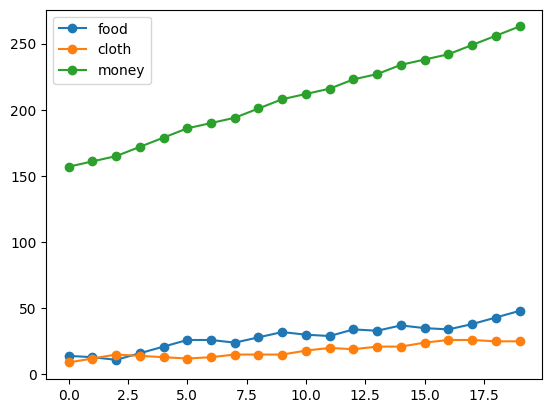

In [18]:
plot_person(econ.farmer)

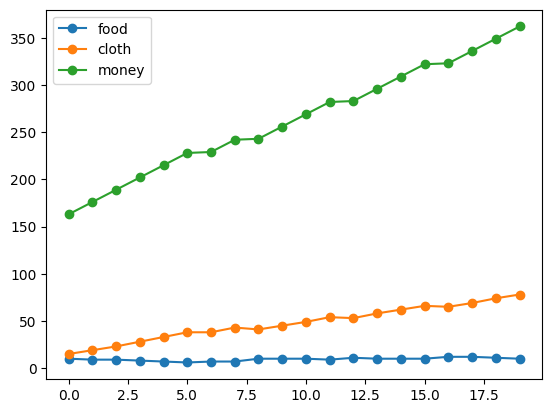

In [19]:
plot_person(econ.carpenter)